/tmp/ipykernel_4933/3094738742.py:14: RuntimeWarning: invalid value encountered in divide
  norm_img[:, :, c] = np.divide(img[:, :, c], rimg[:, :, c])


[[  0   0   0]
 [ 64  33 215]
 [ 84  17 240]
 [ 91  12 251]]


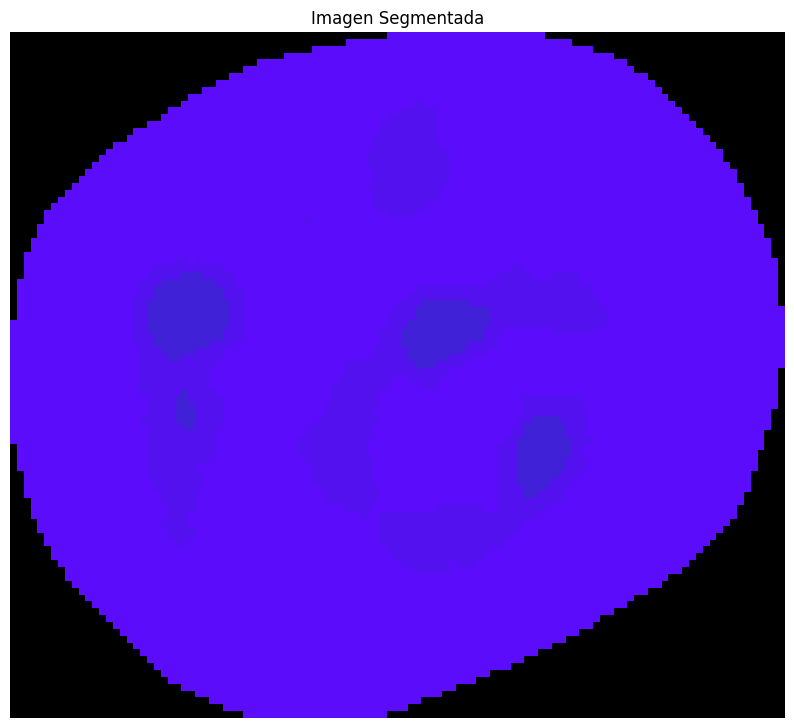

[[ 88  13 253]
 [ 72  23 234]
 [  0   0   0]
 [ 85  15 249]]


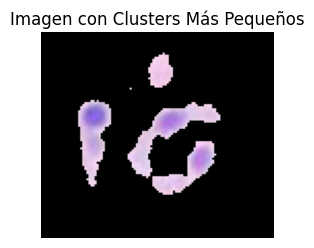

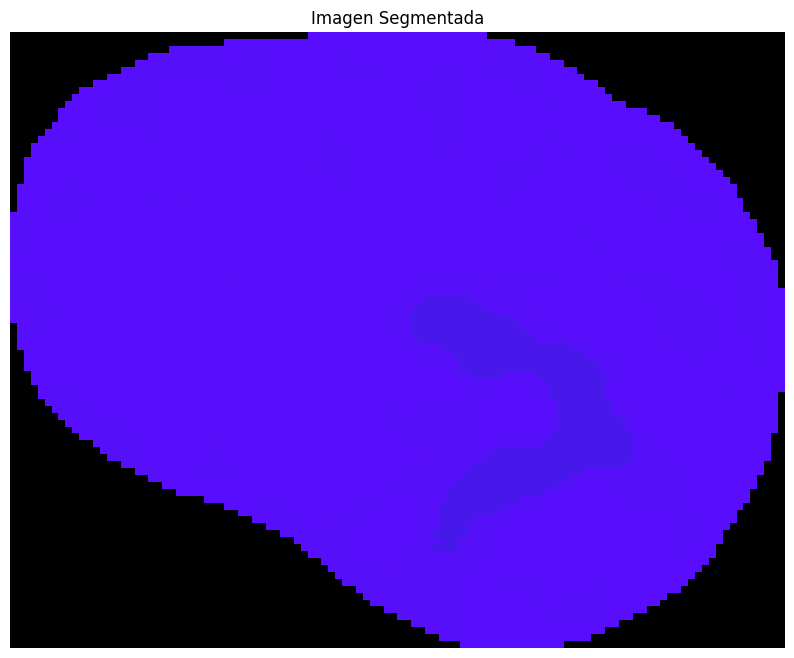

[[ 82  14 251]
 [  0   0   0]
 [ 59  29 220]
 [ 73  18 237]]


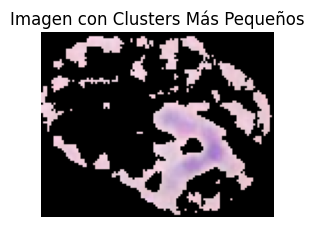

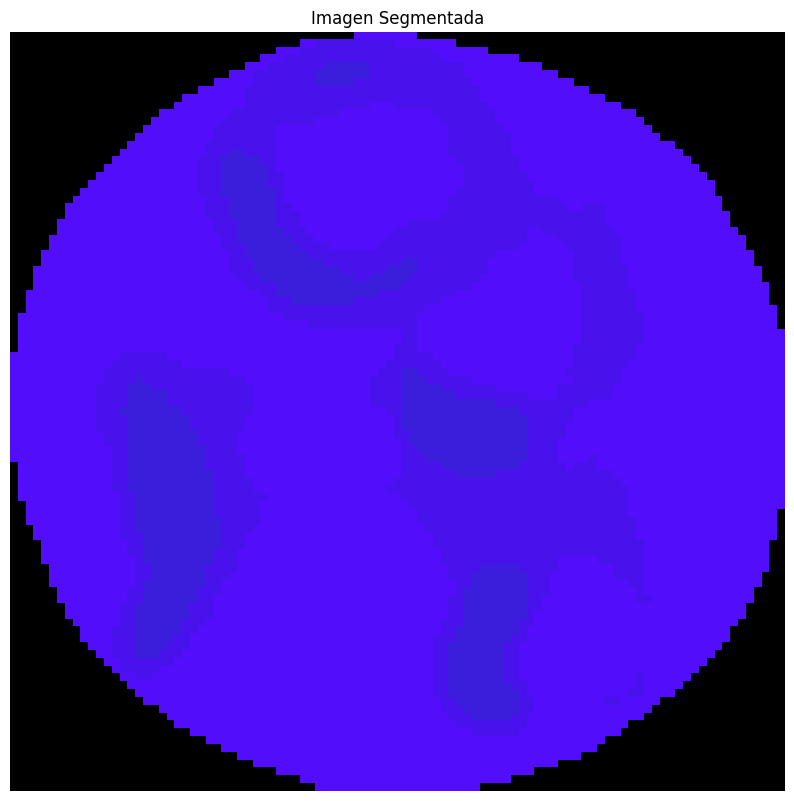

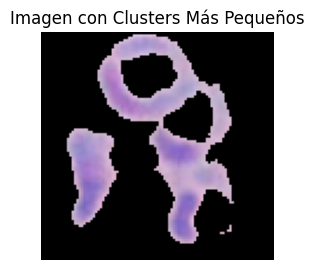

In [25]:
import cv2
import numpy as np
import numpy.typing as npt
from pathlib import Path
from skimage import color as skcolor
import matplotlib.pyplot as plt

def normalize_img(
    img: npt.NDArray[np.float64], rimg: npt.NDArray[np.float64]
) -> npt.NDArray[np.float64]:
    """normalize an image according to a reference image"""
    norm_img: npt.NDArray[np.float64] = np.zeros_like(img, dtype=np.float64)
    for c in range(3):
        norm_img[:, :, c] = np.divide(img[:, :, c], rimg[:, :, c])
        norm_img[:, :, c] = np.nan_to_num(norm_img[:, :, c], nan=0)

    norm_img = np.clip(norm_img, 0, 1)
    return norm_img

# Directorio fuente
src_dir = './img'
folder = Path(src_dir)

# Archivos
files = folder.glob('*_ref.png')

for i in list(files):
    
    image_path = str(i).replace('_ref', "")
    
    # Leer la imagen
    img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    rimg = cv2.cvtColor(cv2.imread(str(i)), cv2.COLOR_BGR2RGB)
    
    # Normalizacion
    norm_img = normalize_img(img, rimg)
    
    # rgbtolab
    lab_image = skcolor.rgb2lab(norm_img)
    lch_image = skcolor.lab2lch(lab_image)
    
    # Redimensionar para clustering
    original_shape = lab_image.shape
    lab_image = lab_image.reshape((-1, 3))
    lch_image = lch_image.reshape((-1, 3))
    
    lab_image = np.float32(lab_image)
    lch_image = np.float32(lch_image)
    
    # Clustering k-means
    stop_criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 1.0)
    number_of_attempts = 30
    centroid_initialization_strategy = cv2.KMEANS_RANDOM_CENTERS
    K = 4
    _, labels, centers = cv2.kmeans(lab_image, K, None, stop_criteria, number_of_attempts, centroid_initialization_strategy)
        
    centers = np.uint8(centers)
    
    print(centers)
    
    segmented_data = centers[labels.flatten()]
    
    # Reconstruir la imagen segmentada
    segmented_image = segmented_data.reshape(original_shape)
    
    # Visualizar la imagen segmentada
    plt.figure(figsize=(10, 10))
    plt.imshow(segmented_image)
    plt.title("Imagen Segmentada")
    plt.axis('off') 
    plt.show()
    
    # Quitar los ceros
    centers = centers[~np.all(centers == 0, axis=1)]
    npixels = []
    
    for k in range(centers.shape[0]):
        mask = np.all(segmented_image.reshape((-1, 3)) == centers[k], axis=1)
        npixels.append(np.count_nonzero(mask))
    
    # Obtener los dos clusters más pequeños
    indices_ordenados = sorted(range(len(npixels)), key=lambda ix: npixels[ix])
    smallest_clusters = indices_ordenados[:2]
    
    # Crear una máscara para los dos clusters más pequeños
    mask = np.zeros(segmented_image.shape[:2], dtype=bool)
    for k in smallest_clusters:
        mask |= np.all(segmented_image == centers[k], axis=-1)
    
    # Aplicar la máscara a la imagen original
    masked_image = np.zeros_like(img)
    masked_image[mask] = img[mask]
    
    # Visualizar la imagen con los clusters más pequeños
    plt.figure(figsize=(3, 3))
    plt.imshow(masked_image)
    plt.title("Imagen con Clusters Más Pequeños")
    plt.axis('off') 
    #plt.show()
